In [33]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Utils.Functions.func_plot_graphs import plot_graphs
from Utils.Functions.func_read_csv_zipped import read_zipped_csv
from Utils.Functions.func_helper_query_dataset import query_dataframe

# Regression Models Lab
## Linear and logistic regression: theory and practice

In this lab you'll revisit and expand on your knowledge of modelling in general, as well as the fundamentals of linear and logistic regression. As a reminder, _linear regression_ is a regression model (regressor), and _logistic regression_ is a classification model (classifier).

This time, you'll use generated data, in order to separate some of the complexity of handling various datasets from inspecting and evaluating models.

**Use vectorization as much as possible!** You should be able to complete the lab using for-loops only to track the training steps.

### Problem 1. Generate some data for multiple linear regression (1 point)
As an expansion to the lecture, you'll create a dataset and a model.

Create a dataset of some (e.g., 50-500) observations of several (e.g., 5-20) independent features. You can use random generators for them; think about what distributions you'd like to use. Let's call them $x_1, x_2, ..., x_m$. The data matrix $X$ you should get should be of size $n \times m$. It's best if all features have different ranges.

Create the dependent variable by assigning coefficients $\bar{a_1}, \bar{a_2}, ..., \bar{a_m}, \bar{b}$ and calculating $y$ as a linear combination of the input features. Add some random noise to the functional values. I've used bars over coefficients to avoid confusion with the model parameters later.

Save the dataset ($X$ and $y$), and "forget" that the coefficients have ever existed. "All" you have is the file and the implicit assumption that there is a linear relationship between $X$ and $y$.

In [12]:
np.random.seed(137)

In [13]:
n = 300
m = 10

x1 = np.random.normal(loc=0, scale=1, size=n)   # normal distribution
x2 = np.random.uniform(-10, 10, size=n)         # uniform distribution
x3 = np.random.exponential(scale=2, size=n)     # exponential
x4 = np.random.normal(loc=50, scale=10, size=n)   # normal distribution
x5 = np.random.uniform(100, 200, size=n)         # uniform distribution
x6 = np.random.normal(loc=-20, scale=5, size=n)     # exponential
x7 = np.random.chisquare(df=2, size=n)                   # Chi-square
x8 = np.random.beta(a=2, b=5, size=n)                    # Beta distribution
x9 = np.random.gamma(shape=2, scale=2, size=n)           # Gamma distribution
x10 = np.random.lognormal(mean=0, sigma=1, size=n)       # Log-normal

In [14]:
X = np.column_stack((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10))

In [15]:
print(X)

[[ 1.09077549  5.92389029  6.90933633 ...  0.30533547  5.98453972
   3.03588178]
 [ 1.06558071 -3.09908189  1.35845295 ...  0.49231351  2.8090298
   0.53510295]
 [ 4.51574031  1.96207806 11.7034479  ...  0.45637429  2.9232067
   0.33918082]
 ...
 [-0.52915439  8.98738407  8.78385832 ...  0.1637413   1.82898391
   0.13470937]
 [ 1.40276318 -6.1409744   0.22752997 ...  0.45564266  3.5241629
   1.03636444]
 [-0.99075326  7.70942206  5.22108736 ...  0.15571819  1.41801531
   1.07151241]]


In [16]:
true_coefficients = np.random.uniform(-5, 5, size=m)     # Random coefficients for each feature
bias = np.random.uniform(-10, 10)                        # Random bias term

# Step 5: Create target variable y using a linear combination + noise
noise = np.random.normal(0, 5, size=n)                   # Gaussian noise
y = X @ true_coefficients + bias + noise                 # Linear relationship with noise

# Step 6: Create a DataFrame with features and target
df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(m)])
df["y"] = y

# Step 7: Save the dataset to a CSV file
df.to_csv("regression_dataset.csv", index=False)

In [17]:
print("Dataset created and saved as 'regression_dataset.csv'")
print("Coefficients and bias are now forgotten.")

Dataset created and saved as 'regression_dataset.csv'
Coefficients and bias are now forgotten.


### Problem 2. Check your assumption (1 point)
Read the dataset you just saved (this is just to simulate starting a new project). It's a good idea to test and verify our assumptions. Find a way to check whether there really is a linear relationship between the features and output.

In [24]:
indent = " " * 0
base_path = os.getcwd()

# f = open('output_log.txt', 'w', encoding='utf-8')
# sys.stdout = f

# Loading dataset config CSV
config_path = os.path.join(base_path, "Utils", "Configs", "datasets_config.csv")
datasets_df = pd.read_csv(config_path)

# Convert CSV config into dictionary with full paths
dataset_paths = {
    row['name']: os.path.normpath(os.path.join(base_path, row['path']))
    for _, row in datasets_df.iterrows()
}

regression_dataset_path = dataset_paths.get('regression_dataset')
regression_dataset = pd.read_csv(regression_dataset_path, encoding='ISO-8859-1')

In [26]:
query_dataframe(regression_dataset, filepath=regression_dataset_path, encoding='ISO-8859-1')

       Encoding check:
                                                
        Filepath: C:\Users\georgi.petrov\DataScience\08.RegressionModelsLab\lab\regression_dataset.csv
        Encoding: ISO-8859-1
        Total lines in file (including header): 301
        Rows loaded in DataFrame: 300
                                                
                                                

   Dataset Summary:
   DataFrame dimensions: (300, 11)
                                                
                                                
                                                

   No missing values detected.
                                                
                                                
                                                

   Duplicate rows: 0
                                                
                                                
                                                

   
    Columns and data types:
      - x1: float64
    

In [28]:
correlations = regression_dataset.corr()["y"].drop("y")
print(correlations)

x1    -0.034929
x2     0.221380
x3    -0.008182
x4     0.290450
x5     0.905902
x6    -0.091314
x7    -0.031393
x8    -0.062187
x9     0.142388
x10   -0.069819
Name: y, dtype: float64


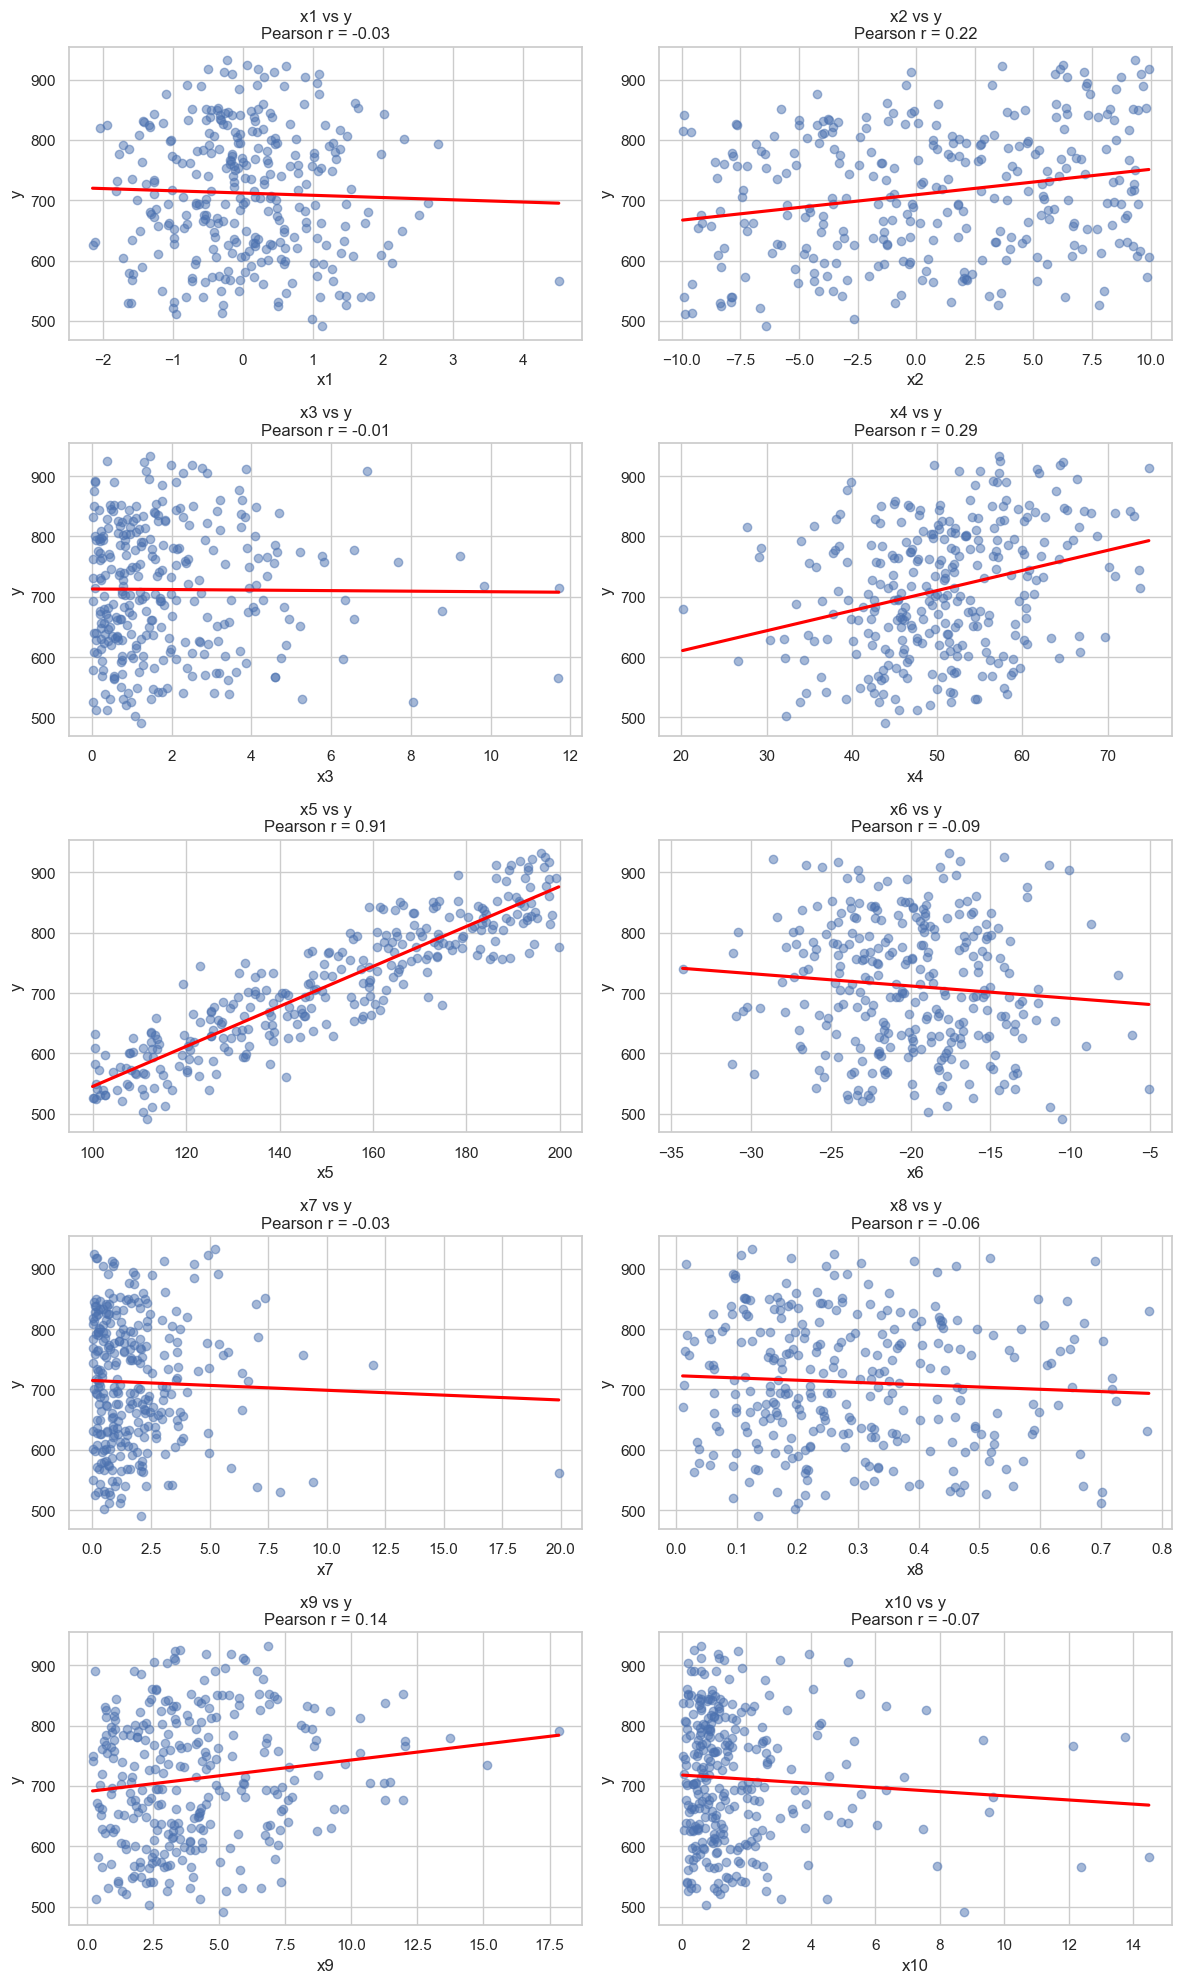

In [34]:
features = regression_dataset.columns[:-1]
n_features = len(features)

# Grid size (e.g., 2 columns)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.regplot(
        data=df,
        x=col,
        y='y',
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'},
        ci=None,
        ax=axes[i]
    )
    # Show correlation on the plot
    corr = df[[col, 'y']].corr().iloc[0, 1]
    axes[i].set_title(f"{col} vs y\nPearson r = {corr:.2f}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

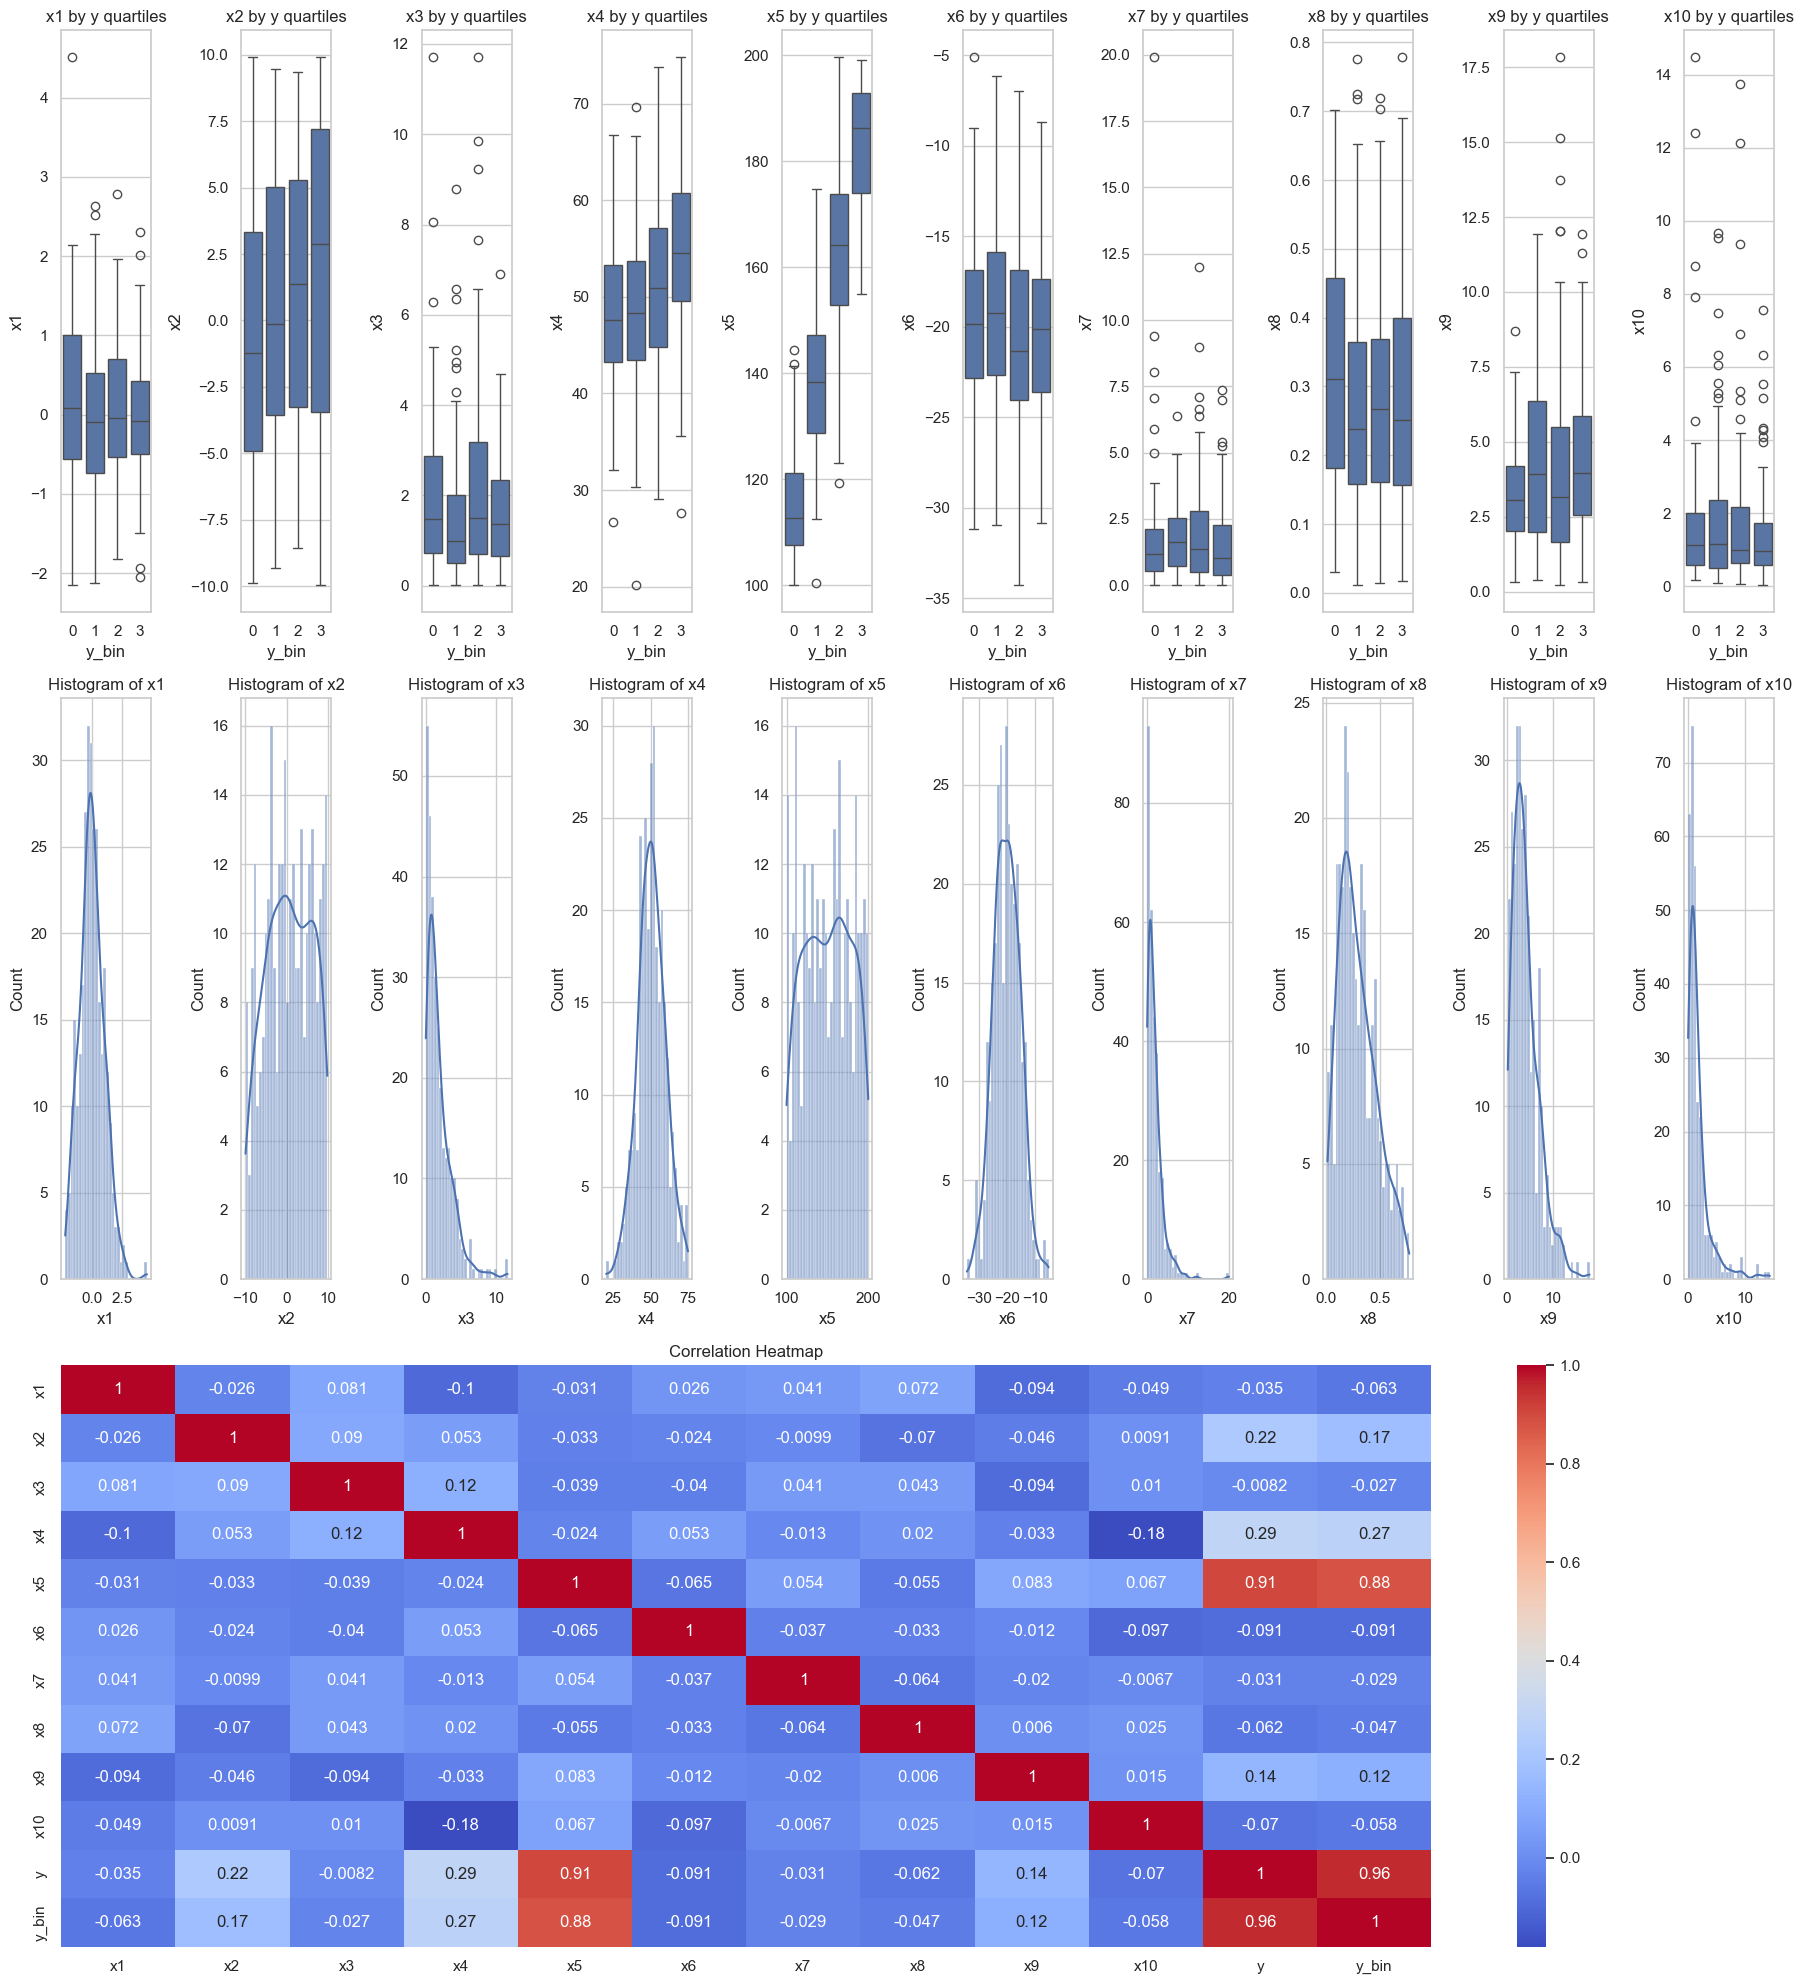

In [36]:
regression_dataset = df.copy()
regression_dataset['y_bin'] = pd.qcut(df['y'], q=4, labels=False)  # Quartile bins for y

features = regression_dataset.columns[:-2]  # features only
n_features = len(features)

# grid layout
fig = plt.figure(figsize=(18, n_features * 2))

# Boxplots
for i, col in enumerate(features):
    ax = plt.subplot(3, n_features, i + 1)  # Row 1
    sns.boxplot(data=regression_dataset, x='y_bin', y=col, ax=ax)
    ax.set_title(f"{col} by y quartiles")

# Histograms
for i, col in enumerate(features):
    ax = plt.subplot(3, n_features, n_features + i + 1)  # Row 2
    sns.histplot(data=regression_dataset, x=col, bins=30, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")

# Correlation Heatmap 
ax = plt.subplot(3, 1, 3)  # Row 3, single plot
corr = regression_dataset.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()

### Problem 3. Figure out the modelling function (1 point)
The modelling function for linear regression is of the form
$$ \tilde{y} = \sum_{i=1}^{m}a_i x_i + b $$

If you want to be clever, you can find a way to represent $b$ in the same way as the other coefficients.

Write a Python function which accepts coefficients and data, and ensure (test) it works correctly.

### Problem 4. Write the cost function and compute its gradients (1 point)
Use MSE as the cost function $J$. Find a way to compute, calculate, or derive its gradients w.r.t. the model parameters $a_1, ..., a_m, b$

Note that computing the cost function value and its gradients are two separate operations. Quick reminder: use vectorization to compute all gradients (maybe with the exception of $\frac{\partial J}{\partial b}$) at the same time.

### Problem 5. Perform gradient descent (1 point)
Perform weight updates iteratively. Find a useful criterion for stopping. For most cases, just using a fixed (large) number of steps is enough.

You'll need to set a starting point (think about which one should be good, and how it matters); and a learning rate.

### Problem 6. Do other cost functions work? (2 points)
Repeat the process in problems 4 and 5 with MAE, and then again - with the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss). Both of them are less sensitive to outliers / anomalies than MSE); with the Huber loss function being specifically made for datasets with outliers.

Explain your findings. Is there a cost function that works much better? How about speed of training (measured in wall time)?

### Problem 7. Experiment with the learning rate (1 point)
Use your favorite cost function. Run several "experiments" with different learning rates. Try really small, and really large values. Observe and document your findings.

### Problem 8. Generate some data for classification (1 point)
You'll need to create two clusters of points (one cluster for each class). I recomment using `scikit-learn`'s `make_blobs()` ([info](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)). Use as many features as you used in problem 1.

### Problem 9. Perform logistic regression (1 point)
Reuse the code you wrote in problems 3-7 as much as possible. If you wrote vectorized functions with variable parameters - you should find this easy. If not - it's not too late to go back and refactor your code.

The modelling function for logistic regression is
$$ \tilde{y} = \frac{1}{1+\exp{(-\sum_{i=1}^{m}a_i x_i + b)}}$$. Find a way to represent it using as much of your previous code as you can.

The most commonly used loss function is the [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy).

Experiment with different learning rates, basically repeating what you did in problem 7.

### * Problem 10. Continue experimenting and delving deep into ML
You just saw how modelling works and how to implement some code. Some of the things you can think about (and I recommend you pause and ponder on some of them are):
* Code: OOP can be your friend sometimes. `scikit-learn`'s models have `fit()`, `predict()` and `score()` methods.
* Data: What approaches work on non-generated data?
* Evaluation: How well do different models (and their "settings" - hyperparameters) actually work in practice? How do we evaluate a model in a meaningful way?
* Optimization - maths: Look at what `optimizers` (or solvers) are used in `scikit-learn` and why. Many "tricks" revolve around making the algorithm converge (finish) in fewer iterations, or making it more numerically stable.
* Optimization - code: Are there ways to make the code run fastr?